Здесь собраны примеры биологических задач, которые я решала с помощью ML на курсах от фонда "Интеллект" на ФББ МГУ, а также некоторые другие примеры

### Импорт необходимых модулей

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

# Биологические задачи



## kNN. Предсказание рака молочной железы

Датасет предоставлен UCI ([описание](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))). Задача - по параметрам предсказать злокачественность опухоли (Malignant / Benign).  

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)
print(data['data'].head())
print()
print(data['target'].head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0           

In [ ]:
X = data['data'] #используем все параметры датасета
y = data['target'] #злокачественность опухоли - целевая переменная

In [ ]:
#разобьем переменные на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#осуществим стандартизацию признаков в выборке

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#обучим модель и сделаем предсказание на стандартизованных данных 

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

In [ ]:
#оценим качество модели с помощью различных метрик бинарной классификации

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



### Дополнение. Подбор числа соседей

Определим функцию, которая будет строить график зависимости качества модели от числа соседей. 

In [ ]:
#на вход подаются стандартизованные X_train, X_test, y_train, y_test
#по умолчанию метрикой (metric) установлен F1-score,
#тестируемое число соседей (limit) - от 1 до 50
def make_qual_chart(X_train, X_test, y_train, y_test, metric=f1_score, limit=50):
    train_quals = np.zeros(limit)
    test_quals = np.zeros(limit)
    param_range = np.arange(1, limit + 1)    
    
    for ind, value in enumerate(param_range):
        model = KNeighborsClassifier(n_neighbors = value)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_quals[ind] = metric(y_true=y_train, y_pred=y_train_pred)
        test_quals[ind] = metric(y_true=y_test, y_pred=y_test_pred)

    plt.figure(figsize=(10, 7))
    plt.plot(param_range, train_quals, label="Train")
    plt.plot(param_range, test_quals, label="Test")
   
    plt.legend()
    plt.show()
    #для показа численных значений необходимо раскомментировать следующую строку:
    #return param_range, train_quals, test_quals


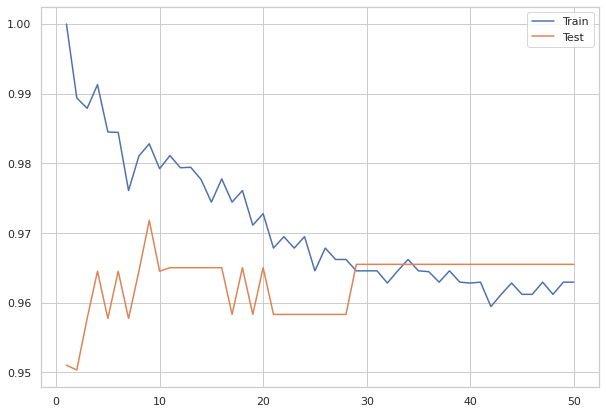

In [ ]:
#протестируем данную функцию с полученными выше данными 

make_qual_chart(X_train_scaled, X_test_scaled, y_train, y_test)

## Линейная регрессия. Геномные эмбеддинги

Так как датасет, на котором я решала эту задачу, не является общедоступным, ниже представлена схема решения. 

Исходная постановка задачи. Прочитана последовательность некоторого регуляторного участка, необходимо по однонуклеотидным заменам в нем предсказать изменение экспрессии гена. 

Предоставленные данные: 


*   Хромосома, на которой расположен ген 
*   Численная позиция
* Исходный нуклеотид
* На какой нуклеотид произведена замена 
* На сколько в условных единицах изменилась экспрессия гена
* Уверенность в измерениях предыдущей колонки 
* Направление изменения
* Название кодируемого белка
* Геномные эмбеддинги данного участка 




In [ ]:
X = tfs.iloc[:,8:] #геномные эмбеддинги
y = tfs["Value"] #изменение экспрессии
#разбиваем на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#стандартизация признаков
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#обучаем модель и делаем предсказание
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_test_pred = linreg.predict(X_test)

#осуществим оценку качества предсказания с помощью коэффициента корреляции Пирсона 
#и графически 
plt.scatter(y_test, y_test_pred, marker=".")
plt.xlabel("Истинные значения", fontsize=14)
plt.ylabel("Предсказанные значения", fontsize=14)
plt.show()


pearsonr(y_test, y_test_pred)

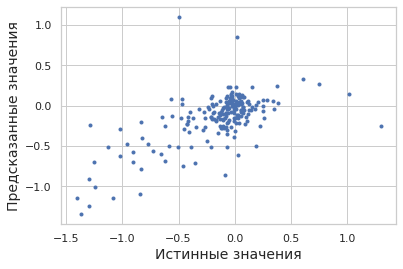


Коэффициент корреляции - 0.64, p-value 2e-24, что лучше предсказания с помощью kNN в той же задаче - 0.56 и 6e-18 соответственно. 

## Логистическая регрессия. Классификация химических веществ

В данной задаче использован датасет [BACE](http://ww82.moleculenet.ai/datasets-1), который был использован ранее в соревнованиях. Необходимая для задания информация был оформлена в виде csv-таблицы.

Суть задачи - предсказать, является ли химическое соединение ингибитором бета-секретазы 1. 

In [ ]:
!wget https://data.bioml.ru/htdocs/courses/bioml/classic_ml/supervised/knn/data/bace.csv

bace = pd.read_csv("./bace.csv", header=0)
print(bace.head())

--2022-12-18 14:51:21--  https://data.bioml.ru/htdocs/courses/bioml/classic_ml/supervised/knn/data/bace.csv
Resolving data.bioml.ru (data.bioml.ru)... 178.62.218.34
Connecting to data.bioml.ru (data.bioml.ru)|178.62.218.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3897767 (3.7M) [text/csv]
Saving to: ‘bace.csv.4’

bace.csv.4          100%[===================>]   3.72M  4.01MB/s    in 0.9s    

2022-12-18 14:51:22 (4.01 MB/s) - ‘bace.csv.4’ saved [3897767/3897767]

                                                 mol     CID  Class  Model  \
0  O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...  BACE_1      1  Train   
1  Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...  BACE_2      1  Train   
2  S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...  BACE_3      1  Train   
3  S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...  BACE_4      1  Train   
4  S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...  BACE_5      1  Train   

      pIC50         MW   AlogP

SMILES - способ кодировать строение химического соединения, далее представлены различные физико-химические свойства вещества (количество хиральных центров, растворимость и т.д.)

In [ ]:
X = bace.iloc[:,4:].values #признаки
y = bace["Class"].values #класс - является ингибитором или нет
smiles = bace["mol"].values #строение вещества

In [ ]:
#разобьем на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
#стандартизуем признаки 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#обучим модель логистической регрессии и сделаем предсказание, оценим качество модели

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=200, penalty = "none")
logreg.fit(X_train_scaled, y_train)
y_test_pred = logreg.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       203
           1       0.92      0.90      0.91       176

    accuracy                           0.92       379
   macro avg       0.92      0.92      0.92       379
weighted avg       0.92      0.92      0.92       379



Чтобы улучшить качество модели, используем регуляризатор ElasticNet.

In [ ]:
init = 0
limit = 1
step = 0.05

param_range = np.arange(init, limit + step, step) #перебираем разные значения l1-ratio
train_quals = np.zeros(len(param_range))
test_quals = np.zeros(len(param_range))

baseline = f1_score(y_true=y_test, y_pred=np.full_like(y_test, y_train.mean()))

for ind, value in tqdm(enumerate(param_range), total=len(param_range)):
    model = LogisticRegression(max_iter=10000, solver="saga", penalty="elasticnet", l1_ratio = value)
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    train_quals[ind] = f1_score(y_true=y_train, y_pred=y_train_pred)
    test_quals[ind] = f1_score(y_true=y_test, y_pred=y_test_pred)

100%|██████████| 21/21 [12:47<00:00, 36.55s/it]


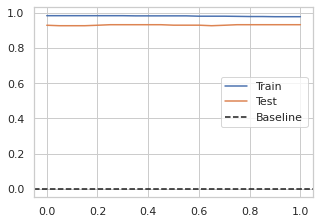

In [ ]:
#Отобразим полученные результаты на графике
plt.figure(figsize=(5, 3.5))
plt.plot(param_range, train_quals, label="Train")
plt.plot(param_range, test_quals, label="Test")
plt.axhline(baseline, color="k", ls="--", lw=1.5, label="Baseline")
plt.legend()
plt.show()

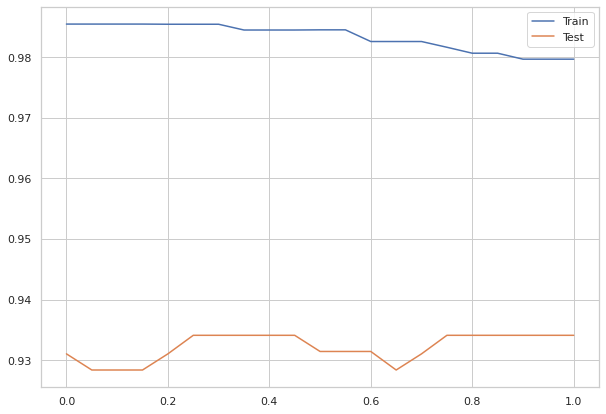

In [ ]:
#прицельно посмотрим на train и test 
plt.figure(figsize=(10, 7))
plt.plot(param_range, train_quals, label="Train")
plt.plot(param_range, test_quals, label="Test")
plt.legend()
plt.show()

Исходя из представленного выше графика можем выбрать один из нескольких вариантов с наилучшей метрикой.


## SVM. Предсказание растворимости веществ


Задача: на основе датасета [ADSoiDB](https://www.nature.com/articles/s41597-019-0151-1), содержащего данные о строении вещества и его физико-химических характеристиках, предсказать его растворимость.

In [ ]:
!wget  https://data.bioml.ru/htdocs/courses/bioml/TEMP/curated-solubility-dataset.csv

--2022-12-19 07:48:01--  https://data.bioml.ru/htdocs/courses/bioml/TEMP/curated-solubility-dataset.csv
Resolving data.bioml.ru (data.bioml.ru)... 178.62.218.34
Connecting to data.bioml.ru (data.bioml.ru)|178.62.218.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3750208 (3.6M) [text/csv]
Saving to: ‘curated-solubility-dataset.csv’

curated-solubility- 100%[===================>]   3.58M  3.59MB/s    in 1.0s    

2022-12-19 07:48:03 (3.59 MB/s) - ‘curated-solubility-dataset.csv’ saved [3750208/3750208]



In [ ]:
data = pd.read_csv("curated-solubility-dataset.csv")
print(data.head())

    ID                                               Name  \
0  A-3         N,N,N-trimethyloctadecan-1-aminium bromide   
1  A-4                           Benzo[cd]indol-2(1H)-one   
2  A-5                               4-chlorobenzaldehyde   
3  A-8  zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...   
4  A-9  4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...   

                                               InChI  \
0  InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...   
1  InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...   
2        InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H   
3  InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...   
4  InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...   

                      InChIKey  \
0  SZEMGTQCPRNXEG-UHFFFAOYSA-M   
1  GPYLCFQEKPUWLD-UHFFFAOYSA-N   
2  AVPYQKSLYISFPO-UHFFFAOYSA-N   
3  XTUPUYCJWKHGSW-UHFFFAOYSA-L   
4  FAUAZXVRLVIARB-UHFFFAOYSA-N   

                                              SMILES  Solubility   SD  \
0                [

In [ ]:
y = data['Solubility'] #предсказываем растворимость
X = data.iloc[:,6:] #на основе физико-химических характеристик
X = X.drop(columns = ['Group'])

In [ ]:
X


,SD,Ocurrences,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,0.000000,1,392.510,3.95810,102.4454,23.0,0.0,0.0,2.0,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,0.000000,1,169.183,2.40550,51.9012,13.0,1.0,1.0,2.0,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,0.000000,1,140.569,2.15250,36.8395,9.0,1.0,0.0,2.0,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,0.000000,1,756.226,8.11610,200.7106,53.0,6.0,2.0,7.0,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,0.000000,1,422.525,2.48540,119.0760,31.0,6.0,0.0,6.0,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,0.000000,1,264.369,2.61700,78.6762,19.0,4.0,1.0,4.0,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548e+00,374.236893
9978,0.000000,1,444.440,-0.21440,109.5409,32.0,9.0,6.0,10.0,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922e+00,1148.584975
9979,0.019222,3,150.221,2.82402,46.9328,11.0,1.0,1.0,1.0,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720e+00,251.049732
9980,0.000000,1,454.611,5.09308,131.6560,33.0,6.0,0.0,6.0,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333e+00,938.203977


In [ ]:
#разобьем на train, val и test - необходима кросс-валидация 
#здесь мы используем метод KFold
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
skf_scores = [] #оценки различных моделей на кросс-валидации
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cross_val = KFold(random_state=42, shuffle = True)


In [ ]:
for train_index, test_index in cross_val.split(X_train, y_train):
    #X_train_, y_train_ = X_train.loc[train_index,:], y_train[train_index]
    #X_val, y_val = X_train.loc[test_index,:], y_train[test_index]
    #X_train, X_val, y_train, y_val = X[train_index,:], X[test_index,:], y[train_index], y[test_index]
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]

    scaler = StandardScaler().fit(X_train_) #проводим стандартизацию признаков
    X_train_ = scaler.transform(X_train_)
    X_val = scaler.transform(X_val)
    #проводим обучение модели
    clf = SVR(random_state = 42)
    clf.fit(X_train_, y_train_)
    pred = clf.predict(X_val)[:, 1]
    skf_scores.append(roc_auc_score(y_val, pred))

#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.6, random_state=42)



ValueError: ignored

In [ ]:
#будем перебирать гиперпараметры в ряду
regularization = [0.001, 10, 0.5, 1, 2.5]

In [ ]:
for i, (train_index, test_index) in enumerate(cross_val.split(X_train, y_train)):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]
    model = SVR(C = regularization[i]) #
    scaler = StandardScaler().fit(X_train_) #проводим стандартизацию признаков
    X_train_ = scaler.transform(X_train_)
    X_val = scaler.transform(X_val)
    #проводим обучение модели
    model.fit(X_train_, y_train_)
    pred = model.predict(X_val)[:, 1]
    skf_scores.append(roc_auc_score(y_val, pred))


KeyError: ignored

In [ ]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'continuous'

## PCA. Снижение размерности. Визуализация.

В данном примере на датасете [GSE53625](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE53625) и метаданных к нему, содержащем данные об экспрессии РНК, произвели снижение размерности и визуализацию данных.

In [ ]:
!wget https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/dim_reduction/data/gse53625.tar.gz -O gse53625.tar.gz
!tar xvzf gse53625.tar.gz

--2022-12-19 08:52:27--  https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/dim_reduction/data/gse53625.tar.gz
Resolving data.bioml.ru (data.bioml.ru)... 178.62.218.34
Connecting to data.bioml.ru (data.bioml.ru)|178.62.218.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1666446 (1.6M) [application/gzip]
Saving to: ‘gse53625.tar.gz’

gse53625.tar.gz     100%[===================>]   1.59M  1.85MB/s    in 0.9s    

2022-12-19 08:52:29 (1.85 MB/s) - ‘gse53625.tar.gz’ saved [1666446/1666446]

data/gse53625_expression.csv
data/gse53625_metadata.csv


In [ ]:
!wget https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/dim_reduction/data/gse53625_expression_corrected.csv -O ./data/gse53625_expression_corrected.csv

--2022-12-19 08:52:34--  https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/dim_reduction/data/gse53625_expression_corrected.csv
Resolving data.bioml.ru (data.bioml.ru)... 178.62.218.34
Connecting to data.bioml.ru (data.bioml.ru)|178.62.218.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13134765 (13M) [text/csv]
Saving to: ‘./data/gse53625_expression_corrected.csv’

./data/gse53625_exp 100%[===================>]  12.53M  8.76MB/s    in 1.4s    

2022-12-19 08:52:37 (8.76 MB/s) - ‘./data/gse53625_expression_corrected.csv’ saved [13134765/13134765]



In [ ]:
#данные после устранения batch-эффекта
#эта задача также была решена, но для упрощения здесь они импортированы
corr = pd.read_csv("./data/gse53625_expression_corrected.csv", index_col = 0)
print(corr.head())

        GSM1296956  GSM1296957  GSM1296958  GSM1296959  GSM1296960  \
gene                                                                 
89253     7.522620    7.179698    7.585947    6.875011    7.378043   
9622      6.041688    7.410923    7.594851    7.491533    7.584632   
13079     8.504730    8.399094   10.042495    8.358348   11.181859   
100371   12.419938   12.889761   11.777923   13.567128   12.511166   
38363    10.440319    9.155329    9.544757    9.819937    9.837136   

        GSM1296961  GSM1296962  GSM1296963  GSM1296964  GSM1296965  ...  \
gene                                                                ...   
89253     7.474826    7.179698    7.185672    7.571609    8.216829  ...   
9622      7.691355    6.495829    6.529890    6.114351    6.244916  ...   
13079     8.138021    9.855367    8.061057    9.441876    8.307039  ...   
100371   13.378970   12.930814   13.348181   12.778007   13.300286  ...   
38363     9.085306    9.709374   10.220421    9.514045    9

In [ ]:
meta = pd.read_csv("data/gse53625_metadata.csv")
X = corr.values.T 
Y = meta["Sample type"]

Доля объясненной дисперсии: 0.27886093397041006


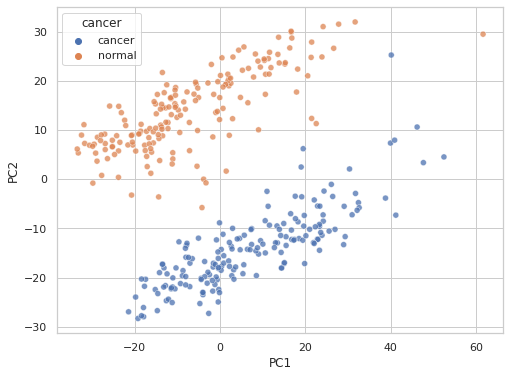

In [ ]:
from sklearn.decomposition import PCA #с помощью метода главных компонент проведем снижение размерности
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) #стандартизируем данные

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df = pd.DataFrame({"PC1": X_pca[:,0],
                   "PC2": X_pca[:,1],
                   "cancer": Y})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="cancer", data=df, alpha=0.75)
variance = np.cumsum(pca.explained_variance_ratio_) 
print('Доля объясненной дисперсии:', variance[1])

## Снижение размерности + кластеризация. tSNE и KMeans

Использовался датасет из предыдущего модуля и метаданные к нему. 

In [ ]:
!wget https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/dim_reduction/data/gse53625.tar.gz -O gse53625.tar.gz
!tar xvzf gse53625.tar.gz

--2022-12-19 12:04:34--  https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/dim_reduction/data/gse53625.tar.gz
Resolving data.bioml.ru (data.bioml.ru)... 178.62.218.34
Connecting to data.bioml.ru (data.bioml.ru)|178.62.218.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1666446 (1.6M) [application/gzip]
Saving to: ‘gse53625.tar.gz’

gse53625.tar.gz     100%[===================>]   1.59M  2.21MB/s    in 0.7s    

2022-12-19 12:04:36 (2.21 MB/s) - ‘gse53625.tar.gz’ saved [1666446/1666446]

data/gse53625_expression.csv
data/gse53625_metadata.csv


In [ ]:
escc = pd.read_csv("./data/gse53625_expression.csv", index_col=0)
escc_meta = pd.read_csv("./data/gse53625_metadata.csv", index_col=0)

In [ ]:
X = escc.values.T #признаки
y = escc_meta["Sample type"] #тип клетки - раковая или нет 
batch = escc_meta["Dataset"] 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


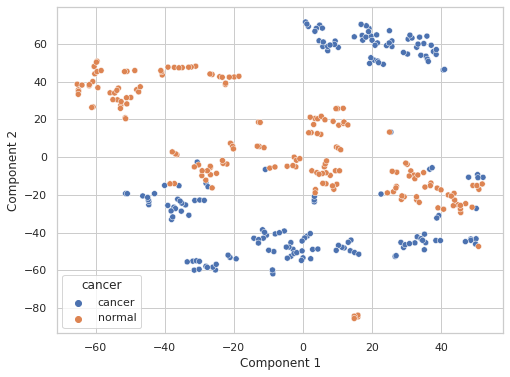

In [ ]:
#осуществим стандартизацию признаков

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#обучим tSNE модель, визуализируем данные 

from sklearn.manifold import TSNE
tsne = TSNE(perplexity = 3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled) 
df = pd.DataFrame({"Component 1": X_tsne[:,0],
                   "Component 2": X_tsne[:,1],
                   "cancer": y})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df)
plt.show()

In [ ]:
#на полученных на tSNE данных обучим модель KMeans, оценим качество индексом Рэнда
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
kmeans = KMeans(n_clusters=2, random_state=42)
z_kmeans = kmeans.fit_predict(X_tsne)
print('Rand score:', adjusted_rand_score(z_kmeans, batch))

Rand score: 0.6361467079098542


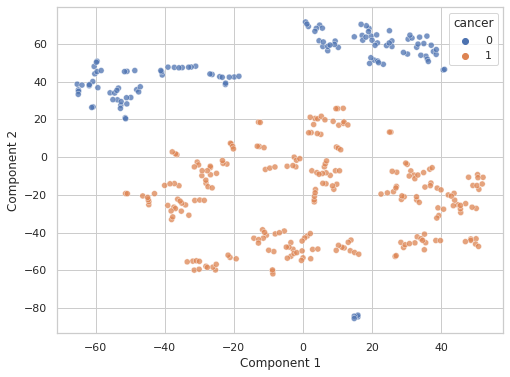

Rand score: 1.0


In [ ]:
#обучим KMeans на исходных данных
z_kmeans_scaled = kmeans.fit_predict(X_scaled) 
df = pd.DataFrame({"Component 1": X_tsne[:,0],
                   "Component 2": X_tsne[:,1],
                   "cancer": z_kmeans_scaled})
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Component 1", y="Component 2", hue="cancer", data=df, alpha=0.75)
plt.show()
print('Rand score:', adjusted_rand_score(z_kmeans_scaled, batch))

Так, мы увидели, что при значительном снижении размерности качество модели снижается, но она все еще лучше бейслайна, хоть и совсем незначительно. А метод KMeans на исходных данных просто запомнил исходные данные, для оценки нужны данные новых экспериментов.

## Построение филогенетических деревьев

Задача решительно специфическая, использует методы и модули, которые характерны в основном для биологии, но тем не менее она интересна.

In [ ]:
!wget https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/data/alignfam.fasta

--2022-12-19 12:25:02--  https://data.bioml.ru/htdocs/courses/bioml/classic_ml/unsupervised/clustering/data/alignfam.fasta
Resolving data.bioml.ru (data.bioml.ru)... 178.62.218.34
Connecting to data.bioml.ru (data.bioml.ru)|178.62.218.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26479 (26K) [application/octet-stream]
Saving to: ‘alignfam.fasta’

alignfam.fasta      100%[===================>]  25.86K  --.-KB/s    in 0s      

2022-12-19 12:25:03 (158 MB/s) - ‘alignfam.fasta’ saved [26479/26479]



In [ ]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 8.7 MB/s 


In [ ]:
#устанавливаем необходимые модули
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

In [ ]:
data = AlignIO.read('alignfam.fasta', 'fasta') #читаем данные
calculator = DistanceCalculator('blosum62') #считаем расстояния между 
#последовательностями генов разных организмов 
#с учетом "штрафов" за непохожесть нуклеотидов
dm = calculator.get_distance(data)
print(dm)

gi|544584820|sp|P29523.4|PPB_BOMMO	0
gi|29427685|sp|Q24238.3|APH4_DROME	0.6618220489188231	0
gi|341941722|sp|P24823.2|PPBN_MOUSE	0.6244897959183673	0.6159156976744187	0
gi|130746|sp|P15693.1|PPBI1_RAT	0.6144712430426715	0.6252684323550466	0.24764663287472843	0
gi|130745|sp|P24822.1|PPBI_MOUSE	0.6234200743494424	0.6275985663082437	0.24773304316285816	0.188348820586133	0
gi|1709730|sp|P51740.1|PPBI2_RAT	0.6455696202531646	0.6428571428571428	0.2885446685878963	0.23120567375886525	0.16165803108808285	0
gi|2507183|sp|P19111.2|PPBI_BOVIN	0.608438193930422	0.6395097332372026	0.28623188405797106	0.2773775216138329	0.2702020202020202	0.3125448028673835	0
gi|130744|sp|P09923.2|PPBI_HUMAN	0.5944341372912801	0.6308871851040525	0.2204437977446344	0.20828789531079606	0.21514379322897703	0.261277517141826	0.2205668604651163	0
gi|130737|sp|P05187.2|PPB1_HUMAN	0.5966604823747681	0.6287988422575976	0.2418537291817524	0.26082251082251084	0.26014492753623186	0.3075268817204301	0.26370851370851367	0.127226

In [ ]:
#строим филогенетическое дерево на основе полученных расстояний
constructor = DistanceTreeConstructor()
UPGMA_tree = constructor.upgma(dm)
UPGMA_tree.ladderize()
Phylo.draw_ascii(UPGMA_tree)

              __________________ gi|2851586|sp|P11491.2|PPB_YEAST
        _____|
       |     |__________________ gi|21542183|sp|O60109.1|PPB_SCHPO
       |
  _____|                  ____________ gi|251757504|sp|P19405.4|PPB3_BACSU
 |     |       __________|
 |     |      |          |____________ gi|239938928|sp|P19406.4|PPB4_BACSU
 |     |______|
 |            |      _________________ gi|134996|sp|P09401.2|STRK_STRGR
 |            |     |
 |            |_____|                  , gi|122260447|sp|Q02QC9.1|PPBH_PSEAB
 |                  |          ________|
 |                  |         |        | gi|12231022|sp|P35483.2|PPBH_PSEAE
_|                  |_________|
 |                            |  _______ gi|130754|sp|P19147.1|PPB_SERMA
 |                            |_|
 |                              |     __ gi|130753|sp|P21948.1|PPB_ESCF3
 |                              |____|
 |                                   |__ gi|130752|sp|P00634.1|PPB_ECOLI
 |
 |      ___________________ gi|2942

## Bagging с различными базовыми моделями

Здесь использовался датасет о раке молочной железы, уже использовавшийся ранее. 

In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC


In [ ]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()

#данная функция не моя
#по датасету считываем
def bootstrap_metric(x, y,
                    metric_fn,
                    samples_cnt=1000,
                    random_state=777):
    size = len(x)
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
    
    return b_metric

In [ ]:
X = breast_cancer.data #признаки
y = breast_cancer.target #класс - злокачественная ли опухоль
#разобьем выборку на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

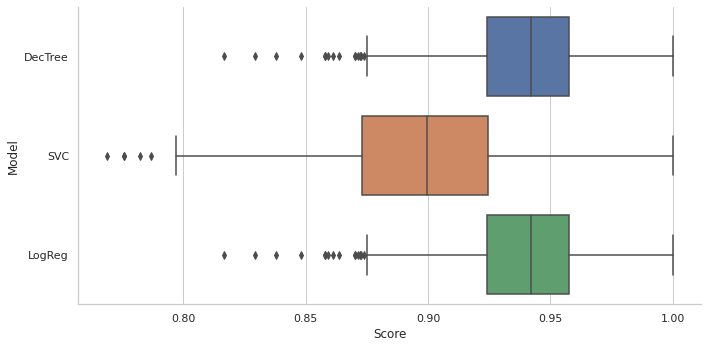

In [ ]:
#проведем bagging с различными моделями - SVC, дерево решений и логистическая регрессия
bagged_svc_model = BaggingClassifier(SVC(), n_estimators=10)
bagged_svc_model.fit(X_train, y_train)
svc_b_pred = bagged_svc_model.predict(X_test)

bagged_tree_model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10)
bagged_tree_model.fit(X_train, y_train)
tree_b_pred = bagged_tree_model.predict(X_test)

bagged_log_model = BaggingClassifier(LogisticRegression(), n_estimators=10)
bagged_log_model.fit(X_train, y_train)
log_b_pred = bagged_tree_model.predict(X_test)
#сравнивать качество модели будем по коэффициенту корреляции Мэтьюса
matthews_m = lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)

boot_score_svc_bagged = bootstrap_metric(y_test, svc_b_pred, metric_fn=matthews_m)
boot_score_tree_bagged = bootstrap_metric(y_test, tree_b_pred, metric_fn=matthews_m)
boot_score_log_bagged = bootstrap_metric(y_test, log_b_pred, metric_fn=matthews_m)

#отобразим полученные результаты на графике
scores = pd.DataFrame({"DecTree": boot_score_tree_bagged,
                       "SVC": boot_score_svc_bagged,
                       "LogReg": boot_score_log_bagged})
scores_melt = pd.melt(scores, var_name="Model", value_name="Score")
scores_melt

sns.catplot(data=scores_melt, x="Score", y="Model", kind="box", aspect=2)
plt.show()

## Градиентный бустинг. SHAP.

Обратимся снова к датасету о раке молочной железы. Теперь будем предсказывать с помощью градиентного бустинга и объяснять полученные результаты, оценивая вклад признаков.


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 7.6 MB/s 


In [ ]:
import sklearn
import xgboost as xgb
import sklearn.ensemble
from sklearn.model_selection import train_test_split
import shap
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#загрузим датасет и разобьем его на train и test
X,y = shap.datasets.boston()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

In [ ]:
#приведем функцию для бутстрепа еще раз 

def bootstrap_metric(x, 
                     y,
                    metric_fn,
                    samples_cnt=1000,
                    alpha=0.05,
                    random_state=777):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
    
    
    return b_metric

In [ ]:
#определим функцию, которая будет запоминать качество модели на каждой итерации
from sklearn.metrics import mean_squared_error
def train_and_test_regressor(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Fitting {name}")
        model.fit(X_train, y_train)
    predictions = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
    boot_scores = {}

    for name, y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        boot_score = bootstrap_metric(y_test, 
                                       y_pred, 
                                       metric_fn=lambda x, y: mean_squared_error(y_true=x, 
                                                                                      y_pred=y))
        boot_scores[name] = boot_score
        
    
    results = pd.DataFrame(boot_scores)
    # cast to long format
    results = results.melt(value_vars=results.columns,
                       value_name="mse", 
                       var_name="model") 
    return results
    

In [ ]:
#запустим LGBMRegressor
import lightgbm
models_add = {}
models_add['lightgbm'] = lightgbm.LGBMRegressor(n_estimators=1000,
                     learning_rate=0.1, 
                     max_depth=-1,
                     num_leaves=2**6,                       
                     random_state=42,
                     min_child_weight=7,
                     n_jobs=-1) 
lgb_add = train_and_test_regressor(models_add, X_train, y_train, X_test, y_test)
print(lgb_add) 

Fitting lightgbm
Calculating bootstrap score for lightgbm


,model,mse
0,lightgbm,19.688675
1,lightgbm,29.459190
2,lightgbm,28.448689
3,lightgbm,25.368264
4,lightgbm,38.805098
...,...,...
995,lightgbm,12.586213
996,lightgbm,37.197233
997,lightgbm,18.150356
998,lightgbm,30.068005


In [ ]:
print('Средний показатель - ', lgb_add.mean())

Средний показатель -  mse    24.794463
dtype: float64


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Сравним с эффективностью другой модели - случайного леса.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)
rf = RandomForestRegressor(n_estimators=200) 

rf.fit(X_scaled_train, y_train)
rf_pred = rf.predict(X_scaled_test)
mse = mean_squared_error(y_test, rf_pred)
print('mse =', mse)

mse = 21.816335075980362


Таким образом, случайный лес быстрее и немного лучше справляется с поставленной задачей. 

Перейдем к объяснению предсказания с помощью SHAP.

In [ ]:
#Для случайного леса
rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer.shap_values(X_scaled_train)
shap.initjs()
shap.force_plot(rf_explainer.expected_value, rf_shap_values[1,:], X.iloc[1,:])

In [ ]:
#Для бустинга - с нуля обучим единичную модель
from lightgbm import LGBMRegressor as lgb
model = lgb (n_estimators = 200, random_state = 777)
model.fit(X = X_train, y = y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])